# Aviation Delay Predictions 

## Preparing the datasets 

##### 1. Importing all necessary libraries

In [1]:
import pandas as pd
import numpy as np
from os import walk
import time
import matplotlib.pyplot as plt
import mpl_toolkits
import seaborn as sns
from sklearn.externals import joblib
%matplotlib inline
sns.set_style('whitegrid')

##### 2. Reading the csv files from January 2018 - November 2018

In [2]:
Jan_df = pd.read_csv('Jan18.csv')
Feb_df = pd.read_csv('Feb18.csv')
Mar_df = pd.read_csv('Mar18.csv')
Apr_df = pd.read_csv('Apr18.csv')
May_df = pd.read_csv('May18.csv')
Jun_df = pd.read_csv('Jun18.csv')
Jul_df = pd.read_csv('Jul18.csv')
Aug_df = pd.read_csv('Aug18.csv')
Sep_df = pd.read_csv('Sep18.csv')
Oct_df = pd.read_csv('Oct18.csv')
Nov_df = pd.read_csv('Nov18.csv')

In [3]:
yr_2018 = [Jan_df, Feb_df, Mar_df, Apr_df, May_df, Jun_df, Jul_df, Aug_df, Sep_df, Oct_df,
         Nov_df]

flights_df = pd.concat(yr_2018)

flights_df.columns

Index(['DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER',
       'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'TAXI_OUT', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'Unnamed: 27'],
      dtype='object')

In [4]:
flights_df.isnull().sum()

DAY_OF_WEEK                  0
FL_DATE                      0
OP_UNIQUE_CARRIER            0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                 65692
DEP_DELAY                65703
TAXI_OUT                 68068
WHEELS_ON                71291
TAXI_IN                  71291
CRS_ARR_TIME                 0
ARR_TIME                 71280
ARR_DELAY                81741
CANCELLED                    0
CANCELLATION_CODE      6379164
CRS_ELAPSED_TIME             0
ACTUAL_ELAPSED_TIME      81741
AIR_TIME                 81741
DISTANCE                     0
CARRIER_DELAY          5218411
WEATHER_DELAY          5218411
NAS_DELAY              5218411
SECURITY_DELAY         5218411
LATE_AIRCRAFT_DELAY    5218411
Unnamed: 27            6447958
dtype: int64

In [5]:
flights_df.shape

(6447958, 28)

In [6]:
flights_df=flights_df.rename(columns = {'OP_UNIQUE_CARRIER':'UNIQUE_CARRIER','OP_CARRIER_FL_NUM':'FL_NUM'})

In [7]:
#flights_df = pd.read_csv('2018flights.csv')

In [8]:
flights_df.drop(['Unnamed: 27','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','OP_CARRIER'],axis=1,inplace=True)

In [9]:
flights_df.columns

Index(['DAY_OF_WEEK', 'FL_DATE', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED',
       'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE'],
      dtype='object')

##### 3. Drop rows with missing data and the NaN values

In [10]:
total_data_rows = len(flights_df.index)
flights_df.dropna(subset = ['ORIGIN','DEST','CRS_DEP_TIME','CRS_ARR_TIME','ARR_DELAY','CRS_ELAPSED_TIME','DISTANCE'],inplace=True)
data_retained = len(flights_df.index)/total_data_rows
print('Data Retained: '+str(round(data_retained*100,2))+' %')

Data Retained: 98.73 %


##### 4. Selecting top 10 airliners

In [11]:
top10_carrier = list(flights_df['UNIQUE_CARRIER'].value_counts().head(10).index)
df_sub = flights_df[flights_df['UNIQUE_CARRIER'].isin(top10_carrier)][['UNIQUE_CARRIER','ORIGIN','DEST','ARR_DELAY']]

In [12]:
carrier_key = pd.read_csv('L_UNIQUE_CARRIERS.csv')
df_sub = pd.merge(df_sub,carrier_key,how='left',left_on='UNIQUE_CARRIER', right_on='Code')

In [13]:
df_temp = df_sub.copy()
df_temp['ARR_DELAY'] = df_temp['ARR_DELAY'].apply(lambda x:30 if x>=30 else x)
df_temp['ARR_DELAY'] = df_temp['ARR_DELAY'].apply(lambda x:-30 if x<=-30 else x)

##### 5.Creating Violin Plot

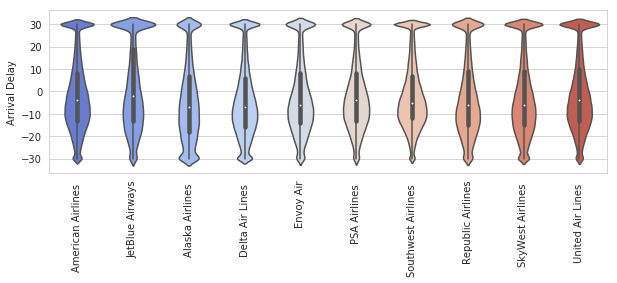

In [15]:
plt.figure(figsize=(10, 3))
g = sns.violinplot(x="Description", y="ARR_DELAY", data=df_temp,palette="coolwarm")
g.set_ylabel('Arrival Delay')
g.set_xlabel('')
label = g.set_xticklabels(g.get_xticklabels(), rotation=90)
fig = g.get_figure()
fig.savefig("delay_violin_plot.png", bbox_inches='tight')

##### 6. Creating plot for delay statistics

In [17]:

carrier_delay = pd.DataFrame()

for UC in list(flights_df['UNIQUE_CARRIER'].unique()):
    perc_delayed = len(flights_df[(flights_df['UNIQUE_CARRIER']==UC) & (flights_df['ARR_DELAY']>=30)].index)/len(flights_df[flights_df['UNIQUE_CARRIER']==UC].index)*100
    carrier_delay = carrier_delay.append({'UNIQUE_CARRIER':UC,'percent_delayed' : perc_delayed},ignore_index=True)

carrier_delay = pd.merge(carrier_delay,carrier_key,how='left',left_on='UNIQUE_CARRIER', right_on='Code')
carrier_delay.drop(['UNIQUE_CARRIER','Code'],axis=1,inplace=True)
carrier_delay.rename(index=str,columns={'Description':'Airline'},inplace=True)
#Sort by percentage delayed
carrier_delay.sort_values(by = ['percent_delayed'],ascending=False,inplace=True)

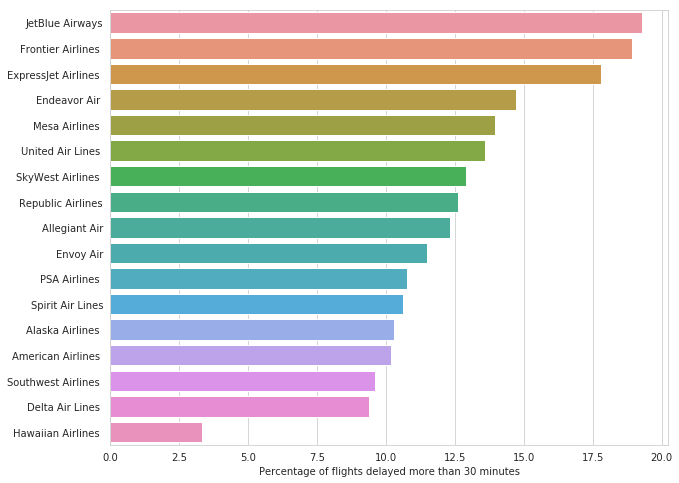

In [19]:

plt.figure(figsize=(10, 8))
g = sns.barplot(x="percent_delayed", y="Airline", data=carrier_delay)
g.set_ylabel('')
g.set_xlabel('Percentage of flights delayed more than 30 minutes')
fig = g.get_figure()
fig.savefig("carrier_delay.png", bbox_inches='tight')

In [15]:
carrier_delay

,percent_delayed,Airline
2,19.271175,JetBlue Airways
8,18.942327,Frontier Airlines
3,17.808318,ExpressJet Airlines
0,14.714152,Endeavor Air
12,13.966266,Mesa Airlines
16,13.585245,United Air Lines
14,12.919512,SkyWest Airlines
13,12.601593,Republic Airlines
15,12.338688,Allegiant Air
7,11.476928,Envoy Air


In [16]:
del df_temp
del carrier_delay
del df_sub

##### 7.Combine Origin and Destination Airports and select top 10 airports

In [17]:
df_airport = pd.DataFrame(pd.concat([flights_df['ORIGIN'],flights_df['DEST']]),columns={'IATA'})
df_airport.shape

(12732434, 1)

In [18]:
df_top10 = pd.DataFrame(df_airport['IATA'].value_counts().head(10)).reset_index()
df_top10.rename(index=str, columns={"index":"IATA","IATA":"Count"},inplace=True)
del df_airport

In [19]:
df_top10.head(10)

,IATA,Count
0,ATL,684937
1,ORD,579095
2,DFW,490490
3,DEN,416086
4,CLT,414172
5,LAX,384439
6,IAH,318318
7,PHX,306504
8,SFO,306251
9,LGA,297495


In [20]:
airports = pd.read_csv("airports.dat")
airports.columns

Index(['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude',
       'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz_database'],
      dtype='object')

In [21]:
airports =airports[airports['Country']=='United States'][['IATA','Latitude','Longitude']].copy()

#Merge with the DataFrame containing the list of Top 50 Airports
df_top10 = pd.merge(df_top10,airports,how='left',on="IATA")

df_top10.to_csv('top10.csv',index=False)

In [22]:
#df_top10=pd.read_csv('top10.csv',low_memory=False)

##### 8. Mapping the airports & creating a bubblemap

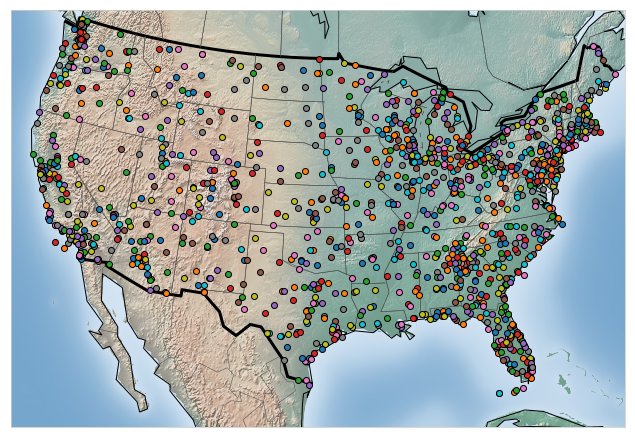

In [23]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(11,11))  
map = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
for index, (y,x) in airports[['Latitude', 'Longitude']].iterrows():
    x, y = map(x, y)
    map.plot(x, y, marker='o',markeredgewidth = 1, markeredgecolor='k')

plt.show()

In [24]:
#Map the Airports as a Bubble map, with size corresponding to Traffic
import plotly.plotly as py

#First create a new columns with Textual information
df_top10['text'] = df_top10['IATA'] + '<br>Total Flights: ' + (df_top10['Count']/1e3).astype(str)+' (Thousands)'

#Create plot using Plotly
limits = [(0,3),(3,7),(7,10)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)"]
names = ["Top 3 Busiest","3-7","7-10"]
cities = []
scale = 2500

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_top10[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Count']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = names[i] )
    cities.append(city)
    
layout = dict(
        title = 'Top 10 Busiest Airports by Traffic',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=cities, layout=layout )
py.iplot( fig, validate=False, filename='d3-map-airports' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~TanayBhatia/0 or inside your plot.ly account where it is named 'd3-map-airports'


/Users/panda/anaconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [25]:
top10_airport = df_top10['IATA'].tolist()
df_sub = flights_df[flights_df['ORIGIN'].isin(top10_airport)]
df_sub = df_sub[df_sub['DEST'].isin(top10_airport)]

data_retained = len(df_sub.index)/len(flights_df.index)
print('Data Retained: '+str(round(data_retained*100,2))+' %')

Data Retained: 6.78 %


##### 9.Plotting the most busy routes

In [26]:
df_airports = pd.DataFrame(df_sub['ORIGIN'].unique())
df_airports.rename(index=str,columns={0:'IATA'},inplace=True)

df_airport_coord = pd.read_csv('airports.dat')
df_airport_coord = df_airport_coord[df_airport_coord['Country']=='United States'][['IATA','Latitude','Longitude']].copy()
df_airports = pd.merge(df_airports,df_airport_coord,how='left',on="IATA")


airport_key = pd.read_csv('L_AIRPORT.csv')
airport_key.rename(index=str, columns={"Code": "IATA"},inplace=True)
df_airports = pd.merge(df_airports,airport_key,how='left',on='IATA')


df_flights = df_sub[['ORIGIN','DEST','ARR_DELAY']].groupby(by=['ORIGIN','DEST']).mean()
df_flights.reset_index(inplace=True)
df_flights['ARR_DELAY'] = df_flights['ARR_DELAY'].apply(lambda x:0 if x<0 else round(x))
df_flights.dropna(inplace=True)

df_flights = df_flights[df_flights['ARR_DELAY']>=10]


df_flights = pd.merge(df_flights,df_airports[['IATA','Latitude','Longitude']],how='left',left_on = 'ORIGIN', right_on = 'IATA')
df_flights.rename(index=str, columns={"Latitude": "start_lat"},inplace=True)
df_flights.rename(index=str, columns={"Longitude": "start_lon"},inplace=True)

df_flights = pd.merge(df_flights,df_airports[['IATA','Latitude','Longitude']],how='left',left_on = 'DEST', right_on = 'IATA')
df_flights.rename(index=str, columns={"Latitude": "end_lat"},inplace=True)
df_flights.rename(index=str, columns={"Longitude": "end_lon"},inplace=True)

df_flights.drop(['IATA_x','IATA_y'],axis=1,inplace=True)


df_flights = df_flights[df_flights['ORIGIN']!='HNL'].copy()
df_flights = df_flights[df_flights['DEST']!='HNL'].copy()
df_airports = df_airports[df_airports['IATA']!='HNL'].copy()

In [27]:
import plotly.plotly as py

airports = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_airports['Longitude'],
        lat = df_airports['Latitude'],
        hoverinfo = 'text',
        text = df_airports['Description'],
        mode = 'markers',
        marker = dict( 
            size=2, 
            color='rgb(0, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ))]
        
flight_paths = []
for i in range( len( df_flights ) ):
    flight_paths.append(
        dict(
            type = 'scattergeo',
            locationmode = 'USA-states',
            lon = [ df_flights['start_lon'][i], df_flights['end_lon'][i] ],
            lat = [ df_flights['start_lat'][i], df_flights['end_lat'][i] ],
            mode = 'lines',
            line = dict(
                #width = 5,
                width = (float((df_flights['ARR_DELAY'][i]-1)-df_flights['ARR_DELAY'].min())/(float(df_flights['ARR_DELAY'].max()-df_flights['ARR_DELAY'].min())/2.0))+2,
                color = 'red'
            ),
            #opacity = 1
            opacity = float(df_flights['ARR_DELAY'][i])/float(df_flights['ARR_DELAY'].max()),
        )
    )
    
layout = dict(
        title = 'Routes with an average delay of more than 10 minutes (2018)',
        showlegend = False, 
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            #scope='north america',
            #projection=dict( type='azimuthal equal area' ),
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict( data=flight_paths + airports, layout=layout )
py.iplot( fig, filename='d3-flight-paths' )

/Users/panda/anaconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [28]:
flights_df.head()


,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE
0,1,2018-11-05,9E,3280,ATL,HPN,1827,1827.0,0.0,37.0,...,4.0,2045,2052.0,7.0,0.0,NaN,138.0,145.0,104.0,780.0
1,1,2018-11-12,9E,3280,ATL,HPN,1827,1834.0,7.0,19.0,...,4.0,2045,2040.0,-5.0,0.0,NaN,138.0,126.0,103.0,780.0
2,1,2018-11-26,9E,3280,ATL,HPN,1827,1921.0,54.0,19.0,...,4.0,2045,2122.0,37.0,0.0,NaN,138.0,121.0,98.0,780.0
3,1,2018-11-19,9E,3280,LGA,RDU,1829,1822.0,-7.0,27.0,...,13.0,2030,2012.0,-18.0,0.0,NaN,121.0,110.0,70.0,431.0
4,1,2018-11-05,9E,3281,ATL,LFT,1300,1255.0,-5.0,18.0,...,4.0,1356,1341.0,-15.0,0.0,NaN,116.0,106.0,84.0,503.0


In [29]:
airport_flights_df=flights_df.copy()

airport_flights_df = airport_flights_df[(airport_flights_df.ORIGIN == "ATL") | (airport_flights_df.ORIGIN == "ORD") | (airport_flights_df.ORIGIN == "DFW") | (airport_flights_df.ORIGIN == "DEN") | (airport_flights_df.ORIGIN == "CLT") | (airport_flights_df.ORIGIN == "LAX") | (airport_flights_df.ORIGIN == "IAH") | (airport_flights_df.ORIGIN == "SFO") | (airport_flights_df.ORIGIN == "PHX") | (airport_flights_df.ORIGIN == "LGA")]  

airport_flights_df = airport_flights_df[(airport_flights_df.DEST == "ATL") | (airport_flights_df.DEST == "ORD") | (airport_flights_df.DEST == "DFW") | (airport_flights_df.DEST == "DEN") | (airport_flights_df.DEST == "CLT") | (airport_flights_df.DEST == "LAX") | (airport_flights_df.DEST == "IAH") | (airport_flights_df.DEST == "SFO") | (airport_flights_df.DEST == "PHX") | (airport_flights_df.DEST == "LGA")]

airport_flights_df.shape

(431420, 21)

In [30]:
airport_flights_df ['DEP_HOUR'] = airport_flights_df ['CRS_DEP_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
#For ARR_HOUR, take the actual arrival time
airport_flights_df['ARR_HOUR'] = airport_flights_df ['ARR_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
airport_flights_df ['ARR_HOUR'] = airport_flights_df ['ARR_HOUR'].apply(lambda x:0 if x==24 else x)



In [31]:
# airport_flights_df.FL_DATE = airport_flights_df.FL_DATE.str.replace('-', '')
airport_flights_df.head()

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DEP_HOUR,ARR_HOUR
604,1,2018-11-05,9E,3422,CLT,LGA,1030,1045.0,15.0,21.0,...,1227.0,-2.0,0.0,NaN,119.0,102.0,75.0,544.0,10,12
605,1,2018-11-12,9E,3422,CLT,LGA,1030,1025.0,-5.0,22.0,...,1216.0,-13.0,0.0,NaN,119.0,111.0,81.0,544.0,10,12
606,1,2018-11-19,9E,3422,CLT,LGA,1030,1026.0,-4.0,13.0,...,1208.0,-21.0,0.0,NaN,119.0,102.0,79.0,544.0,10,12
607,1,2018-11-26,9E,3422,CLT,LGA,1030,1106.0,36.0,39.0,...,1301.0,32.0,0.0,NaN,119.0,115.0,71.0,544.0,10,13
1186,1,2018-11-12,9E,5365,LGA,CLT,1902,2015.0,73.0,34.0,...,2225.0,67.0,0.0,NaN,136.0,130.0,91.0,544.0,19,22


In [32]:
airport_flights_df.drop(['DEP_TIME','TAXI_OUT','WHEELS_ON','TAXI_IN','ARR_TIME','ACTUAL_ELAPSED_TIME',
                         'AIR_TIME', 'CRS_ELAPSED_TIME',
                       'CRS_DEP_TIME','CRS_ARR_TIME'], axis=1,inplace=True)

airport_flights_df.dtypes

DAY_OF_WEEK            int64
FL_DATE               object
UNIQUE_CARRIER        object
FL_NUM                 int64
ORIGIN                object
DEST                  object
DEP_DELAY            float64
ARR_DELAY            float64
CANCELLED            float64
CANCELLATION_CODE     object
DISTANCE             float64
DEP_HOUR               int64
ARR_HOUR               int64
dtype: object

In [33]:
airport_flights_df.to_csv('airport_flights_df',index=False)

In [34]:
weather_df = pd.read_csv('weather.csv', low_memory=False)
weather_df.dtypes

STATION                               object
STATION_NAME                          object
ELEVATION                            float64
LATITUDE                             float64
LONGITUDE                            float64
DATE                                  object
REPORTTPYE                            object
HOURLYSKYCONDITIONS                   object
HOURLYVISIBILITY                      object
HOURLYPRSENTWEATHERTYPE               object
HOURLYDRYBULBTEMPF                    object
HOURLYDRYBULBTEMPC                    object
HOURLYWETBULBTEMPF                   float64
HOURLYWETBULBTEMPC                   float64
HOURLYDewPointTempF                   object
HOURLYDewPointTempC                   object
HOURLYRelativeHumidity               float64
HOURLYWindSpeed                       object
HOURLYWindDirection                   object
HOURLYWindGustSpeed                  float64
HOURLYStationPressure                 object
HOURLYPressureTendency               float64
HOURLYPres

##### 8.Select the weather parameters which affect flight status: Visibility, Temperature, Wind Speed, Precipitation

In [35]:
weather_df = weather_df[['STATION_NAME','DATE','HOURLYVISIBILITY','HOURLYDRYBULBTEMPC','HOURLYWindSpeed','HOURLYPrecip']].copy()

In [36]:
weather_df.shape

(118009, 6)

In [37]:
#Replacing Long Format Station Names with IATA Airport codes
weather_df['STATION_NAME'].replace('ATLANTA HARTSFIELD INTERNATIONAL AIRPORT GA US','ATL',inplace=True)
weather_df['STATION_NAME'].replace('CHICAGO OHARE INTERNATIONAL AIRPORT IL US','ORD',inplace=True)
weather_df['STATION_NAME'].replace('CHICAGO OHARE INTERNATIONAL AIRPORT IL US','ORD',inplace=True)
weather_df['STATION_NAME'].replace('LOS ANGELES INTERNATIONAL AIRPORT CA US','LAX',inplace=True)
weather_df['STATION_NAME'].replace('SAN FRANCISCO INTERNATIONAL AIRPORT CA US','SFO',inplace=True)
weather_df['STATION_NAME'].replace('PHOENIX SKY HARBOR INTERNATIONAL AIRPORT AZ US','PHX',inplace=True)
weather_df['STATION_NAME'].replace('HOUSTON INTERCONTINENTAL AIRPORT TX US','IAH',inplace=True)
weather_df['STATION_NAME'].replace('DAL FTW WSCMO AIRPORT TX US','DFW',inplace=True)
weather_df['STATION_NAME'].replace('LA GUARDIA AIRPORT NY US','LGA',inplace=True)
weather_df['STATION_NAME'].replace('DENVER INTERNATIONAL AIRPORT CO US','DEN',inplace=True)
weather_df['STATION_NAME'].replace('CHARLOTTE DOUGLAS AIRPORT NC US','CLT',inplace=True)

In [38]:
weather_df.head()

,STATION_NAME,DATE,HOURLYVISIBILITY,HOURLYDRYBULBTEMPC,HOURLYWindSpeed,HOURLYPrecip
0,DEN,2018-01-01 00:53,8.00,-13.3,8,T
1,DEN,2018-01-01 01:53,9.00,-12.8,5,T
2,DEN,2018-01-01 02:00,NaN,-12.8,5,NaN
3,DEN,2018-01-01 02:53,8.00,-12.2,0,T
4,DEN,2018-01-01 03:53,5.00,-12.2,5,T


In [40]:
df_weather=weather_df.copy()

def tryconvert(x):
        try:
            if str(x)[-1].isalpha():
                return(float(str(x)[:-1]))
            else:
                return(float(str(x)))
        except:
            return(np.nan)

#Get the Year, Month, Date and Hour from df_weather
#Delete duplicate rows with data from the same station and same date/hour
#Delete "DATE"

df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])

df_weather['YEAR']= df_weather['DATE'].apply(lambda time: time.year)
df_weather['MONTH']= df_weather['DATE'].apply(lambda time: time.month)
df_weather['DAY_OF_MONTH']= df_weather['DATE'].apply(lambda time: time.day)
df_weather['HOUR']= df_weather['DATE'].apply(lambda time: time.hour)

df_weather.drop_duplicates(['STATION_NAME','YEAR','MONTH','DAY_OF_MONTH','HOUR'],inplace=True)
df_weather.drop('DATE',axis = 1,inplace=True)

df_weather['HOURLYVISIBILITY'] = df_weather['HOURLYVISIBILITY'].apply(lambda x: tryconvert(x))
df_weather['HOURLYDRYBULBTEMPC'] = df_weather['HOURLYDRYBULBTEMPC'].apply(lambda x: tryconvert(x))
df_weather['HOURLYWindSpeed'] = df_weather['HOURLYWindSpeed'].apply(lambda x: tryconvert(x))
df_weather['HOURLYPrecip'] = df_weather['HOURLYPrecip'].apply(lambda x: tryconvert(x))

#Replace NaNs with 0 in Hourly Precip
df_weather['HOURLYPrecip'].fillna(value=0,inplace=True)
#Replace NaNs with average value for Hourly Visibility
df_weather['HOURLYVISIBILITY'].fillna(df_weather['HOURLYVISIBILITY'].mean(),inplace=True

In [41]:
airport_flights_df.head()

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,DEP_DELAY,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DISTANCE,DEP_HOUR,ARR_HOUR
604,1,2018-11-05,9E,3422,CLT,LGA,15.0,-2.0,0.0,NaN,544.0,10,12
605,1,2018-11-12,9E,3422,CLT,LGA,-5.0,-13.0,0.0,NaN,544.0,10,12
606,1,2018-11-19,9E,3422,CLT,LGA,-4.0,-21.0,0.0,NaN,544.0,10,12
607,1,2018-11-26,9E,3422,CLT,LGA,36.0,32.0,0.0,NaN,544.0,10,13
1186,1,2018-11-12,9E,5365,LGA,CLT,73.0,67.0,0.0,NaN,544.0,19,22


In [42]:
airport_flights_df['FL_DATE'] = pd.to_datetime(airport_flights_df['FL_DATE'])
airport_flights_df['YEAR']= airport_flights_df['FL_DATE'].apply(lambda time: time.year)
airport_flights_df['MONTH']= airport_flights_df['FL_DATE'].apply(lambda time: time.month)
airport_flights_df['DAY_OF_MONTH']=airport_flights_df['FL_DATE'].apply(lambda time: time.day)
# airport_flights_df['HOUR']= airport_flights_df['HOUR'].apply(lambda time: time.hour)

#airport_flights_df.drop_duplicates(['ORIGIN','DEST','YEAR','MONTH','DAY_OF_MONTH','HOUR'],inplace=True)
#airport_flights_df.drop('FL_DATE',axis = 1,inplace=True)
airport_flights_df.shape

(431420, 16)

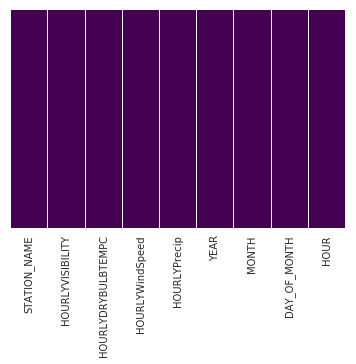

In [43]:
#Check for any missing data:`
#Missing data will show up as Yellow lines
sns.heatmap(df_weather.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [44]:
#df_weather.to_csv('weather2.csv',index=False)

In [45]:
df_avg_DEP = df_weather.groupby('STATION_NAME').mean()
df_avg_DEP.drop(['YEAR','MONTH','DAY_OF_MONTH','HOUR'],axis = 1,inplace=True)
df_avg_DEP.reset_index(drop=False,inplace=True)
df_avg_DEP.rename(index=str, columns={"STATION_NAME": "ORIGIN"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HOURLYVISIBILITY": "DEP_AVG_HOURLYVISIBILITY"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HOURLYDRYBULBTEMPC": "DEP_AVG_HOURLYDRYBULBTEMPC"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HOURLYWindSpeed": "DEP_AVG_HOURLYWindSpeed"},inplace=True)
df_avg_DEP.rename(index=str, columns={"HOURLYPrecip": "DEP_AVG_HOURLYPrecip"},inplace=True)

df_avg_ARR = df_weather.groupby('STATION_NAME').mean()
df_avg_ARR.drop(['YEAR','MONTH','DAY_OF_MONTH','HOUR'],axis = 1,inplace=True)
df_avg_ARR.reset_index(drop=False,inplace=True)
df_avg_ARR.rename(index=str, columns={"STATION_NAME": "DEST"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HOURLYVISIBILITY": "ARR_AVG_HOURLYVISIBILITY"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HOURLYDRYBULBTEMPC": "ARR_AVG_HOURLYDRYBULBTEMPC"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HOURLYWindSpeed": "ARR_AVG_HOURLYWindSpeed"},inplace=True)
df_avg_ARR.rename(index=str, columns={"HOURLYPrecip": "ARR_AVG_HOURLYPrecip"},inplace=True)

In [46]:
#Create two copies of the Weather Dataframe, so that we can two Joins, one for Origin, and one for Destination
df_weather_origin = df_weather.copy()
df_weather_dest = df_weather.copy()

#Rename the Columns, add DEP_ to each column name and STATION_NAME to ORIGIN
df_weather_origin.rename(index=str, columns={"STATION_NAME": "ORIGIN"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOURLYVISIBILITY": "DEP_HOURLYVISIBILITY"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOURLYDRYBULBTEMPC": "DEP_HOURLYDRYBULBTEMPC"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOURLYWindSpeed": "DEP_HOURLYWindSpeed"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOURLYPrecip": "DEP_HOURLYPrecip"},inplace=True)
df_weather_origin.rename(index=str, columns={"HOUR": "DEP_HOUR"},inplace=True)

#Rename the Columns, add ARR_ to each column name and STATION_NAME to DEST
df_weather_dest.rename(index=str, columns={"STATION_NAME": "DEST"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOURLYVISIBILITY": "ARR_HOURLYVISIBILITY"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOURLYDRYBULBTEMPC": "ARR_HOURLYDRYBULBTEMPC"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOURLYWindSpeed": "ARR_HOURLYWindSpeed"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOURLYPrecip": "ARR_HOURLYPrecip"},inplace=True)
df_weather_dest.rename(index=str, columns={"HOUR": "ARR_HOUR"},inplace=True)

df_weather_dest.head()

,DEST,ARR_HOURLYVISIBILITY,ARR_HOURLYDRYBULBTEMPC,ARR_HOURLYWindSpeed,ARR_HOURLYPrecip,YEAR,MONTH,DAY_OF_MONTH,ARR_HOUR
0,DEN,8.000000,-13.3,8.0,0.0,2018,1,1,0
1,DEN,9.000000,-12.8,5.0,0.0,2018,1,1,1
2,DEN,9.322264,-12.8,5.0,0.0,2018,1,1,2
4,DEN,5.000000,-12.2,5.0,0.0,2018,1,1,3
5,DEN,6.000000,-12.2,6.0,0.0,2018,1,1,4


In [47]:
 df_weather_origin.head()

,ORIGIN,DEP_HOURLYVISIBILITY,DEP_HOURLYDRYBULBTEMPC,DEP_HOURLYWindSpeed,DEP_HOURLYPrecip,YEAR,MONTH,DAY_OF_MONTH,DEP_HOUR
0,DEN,8.000000,-13.3,8.0,0.0,2018,1,1,0
1,DEN,9.000000,-12.8,5.0,0.0,2018,1,1,1
2,DEN,9.322264,-12.8,5.0,0.0,2018,1,1,2
4,DEN,5.000000,-12.2,5.0,0.0,2018,1,1,3
5,DEN,6.000000,-12.2,6.0,0.0,2018,1,1,4


In [48]:
# airport_flights_df.rename(columns={'Hour':'HOUR'},inplace=True)
airport_flights_df.shape

(431420, 16)

In [49]:
#Merge the Actual Weather during Take-off and Landing for each flight 
airport_flights_df = pd.merge(airport_flights_df, df_weather_origin, on=['ORIGIN','YEAR','MONTH','DAY_OF_MONTH','DEP_HOUR'], how='left')
airport_flights_df= pd.merge(airport_flights_df, df_weather_dest, on=['DEST','YEAR','MONTH','DAY_OF_MONTH','ARR_HOUR'], how='left')


In [50]:
airport_flights_df.shape

(431420, 24)

In [51]:
#Merge the Average weather for Origin and Destination Airports for each flight:
airport_flights_df = pd.merge(airport_flights_df,df_avg_DEP,how='left',on='ORIGIN')


In [53]:
airport_flights_df.shape

(431420, 28)

In [54]:
airport_flights_df= pd.merge(airport_flights_df,df_avg_ARR,how='left',on='DEST')

In [55]:
airport_flights_df.shape

(431420, 32)

In [56]:
airport_flights_df.dtypes

DAY_OF_WEEK                            int64
FL_DATE                       datetime64[ns]
UNIQUE_CARRIER                        object
FL_NUM                                 int64
ORIGIN                                object
DEST                                  object
DEP_DELAY                            float64
ARR_DELAY                            float64
CANCELLED                            float64
CANCELLATION_CODE                     object
DISTANCE                             float64
DEP_HOUR                               int64
ARR_HOUR                               int64
YEAR                                   int64
MONTH                                  int64
DAY_OF_MONTH                           int64
DEP_HOURLYVISIBILITY                 float64
DEP_HOURLYDRYBULBTEMPC               float64
DEP_HOURLYWindSpeed                  float64
DEP_HOURLYPrecip                     float64
ARR_HOURLYVISIBILITY                 float64
ARR_HOURLYDRYBULBTEMPC               float64
ARR_HOURLY

In [57]:
airport_flights_df.to_csv('final.csv',index=False)

In [66]:
df2 = airport_flights_df.loc[np.random.choice(airport_flights_df.index, airport_flights_df.index.size, replace = False)]
df2.to_csv('medium_data.csv',index=False)

In [67]:
airport_flights_df.dtypes

DAY_OF_WEEK                              int64
FL_DATE                         datetime64[ns]
UNIQUE_CARRIER                          object
FL_NUM                                   int64
ORIGIN                                  object
DEST                                    object
DEP_DELAY                              float64
ARR_DELAY                              float64
CANCELLED                              float64
CANCELLATION_CODE                       object
DISTANCE                               float64
DEP_HOUR                                 int64
ARR_HOUR                                 int64
YEAR                                     int64
MONTH                                    int64
DAY_OF_MONTH                             int64
DEP_HOURLYVISIBILITY                   float64
DEP_HOURLYDRYBULBTEMPC                 float64
DEP_HOURLYWindSpeed                    float64
DEP_HOURLYPrecip                       float64
ARR_HOURLYVISIBILITY                   float64
ARR_HOURLYDRY

In [68]:
airport_flights_df.shape

(431420, 40)